<a href="https://colab.research.google.com/github/cwerries/IANNWTF_Group_14_Submissions/blob/master/Hw08_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Data pipeline

In [2]:
def prepare(mnist, noise_factor):
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img : tf.cast(img, tf.float32))
  
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1] -> (img/128.)-1.
  mnist = mnist.map(lambda img: img/255.)

  mnist = mnist.map(lambda img: tf.expand_dims(img, axis = -1))

  # add noise to inputs
  noisy_mnist = mnist.map(lambda img: img + noise_factor * tf.random.normal(img.shape, 0.2, 0.8, dtype=tf.dtypes.float32))

  noisy_mnist = noisy_mnist.map(lambda img : tf.clip_by_value(img, 0, 1)) 

  #zipping noised dataset as input and original dataset as target
  prepared_mnist = tf.data.Dataset.zip((noisy_mnist, mnist))
  
  #shuffle, batch, prefetch
  prepared_mnist = prepared_mnist.shuffle(1500)
  prepared_mnist = prepared_mnist.batch(1000)
  prepared_mnist = prepared_mnist.prefetch(1000)

  #return preprocessed dataset
  return prepared_mnist

# Autoencoder classes

## Encoder

In [3]:
class Encoder(tf.keras.Model):

  def __init__(self):
    super(Encoder, self).__init__()
    
    self.conv_layer_1 = tf.keras.layers.Conv2D(16, (2, 2), strides = 2, activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(0.001), input_shape=(28, 28, 1)) 
    self.conv_layer_2 = tf.keras.layers.Conv2D(8, (2, 2), strides = 2, activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(0.001)) 
    self.flatten_layer = tf.keras.layers.Flatten()
    self.dens_layer_1 = tf.keras.layers.Dense(10)

  @tf.function
  def call(self, inputs):
    x = self.conv_layer_1(inputs)
    x = self.conv_layer_2(x)
    x = self.flatten_layer(x)
    x = self.dens_layer_1(x)

    return x

## Decoder

In [4]:
class Decoder(tf.keras.Model):

  def __init__(self):
    super(Decoder, self).__init__()

    self.dense_layer_1 = tf.keras.layers.Dense(392)
    self.reshape_layer = tf.keras.layers.Reshape((7, 7, 8))
    self.conv_layer_t_1 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides = 2, activation='relu', padding='same', kernel_regularizer = tf.keras.regularizers.L2(0.001), input_shape=(24, 24, 8))
    self.conv_layer_t_2 = tf.keras.layers.Conv2DTranspose(1, (3, 3), strides = 2, padding='same', kernel_regularizer = tf.keras.regularizers.L2(0.001)) 


  @tf.function
  def call(self, inputs):
    x = self.dense_layer_1(inputs)
    x = self.reshape_layer(x)
    x = self.conv_layer_t_1(x)
    x = self.conv_layer_t_2(x)
    return x

## Denoiser

In [5]:
# Description: To decoise noisy image data
class ConvAutoencoder(tf.keras.Model):
    
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder and Decoder
        self.encoder = Encoder()
        self.decoder = Decoder()
     

    @tf.function
    def call(self, inputs):
        encoded = self.encoder(inputs)
        output = self.decoder(encoded) 
        return encoded, output

# Testing and training

In [6]:
#Description: This function trains an object of the class MyModel. It conducts a forward-step and the backpropagation 
#             throughout the network. The optimizer updates weights and biases. 
#             Inputs: model, inputs, target, loss function, optimizer
#             Outputs:loss, accuracy
def train_step(model, inputs, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
      _, prediction = model(inputs)
      loss = loss_function(target, prediction)
      sample_train_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
      sample_train_accuracy = np.mean(sample_train_accuracy)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  
  return loss, sample_train_accuracy


#Description: This function determines the test loss and test accuracy through a forward step in the network.
#             Inputs: model, test data, loss function
#             Outputs: test loss, test accuracy
def test(model, test_data, loss_function, visualize):
  test_accuracy_aggregator = []
  test_loss_aggregator = []
  embedded_inputs = []
  for (input, target) in test_data:
      embedded_input, prediction = model(input)        
      sample_test_loss = loss_function(target, prediction)
      sample_test_accuracy =  tf.equal(tf.argmax(prediction, 1), tf.argmax(target, 1))
      sample_test_accuracy = np.mean(sample_test_accuracy)
      test_loss_aggregator.append(sample_test_loss.numpy())
      test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
      embedded_inputs.append(embedded_input)
  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  if visualize == True:
    print("Original and denoised image : ")
    plt.imshow(tf.squeeze(target[-1]).numpy())
    plt.show()
    plt.imshow(tf.squeeze(input[-1]).numpy())
    plt.show()
    plt.imshow(tf.squeeze(prediction[-1]).numpy())
    plt.show()

  return test_loss, test_accuracy, embedded_input

# Plot Visualization

In [7]:
# Description: This function visualizes the losses and accuracies of training and testing
#              @parameters: train_losses, test_losses, train_accuracies, test_accuracies
#              @returns: plot

def visualization(train_losses, test_losses, train_accuracies, test_accuracies):
  # Visualization of losses
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.title("Training and testing loss")
  plt.xlabel("Training steps")
  plt.ylabel("loss")
  plt.legend((line1, line2), ("Training", "Testing"), fontsize=12)
  plt.show()

  #Visualization of accuracies
  plt.figure()
  line3, = plt.plot(test_accuracies)
  line4, = plt.plot(train_accuracies)
  plt.title("Training and testing accuracies")
  plt.xlabel("Training steps")
  plt.ylabel("Accuracy")
  plt.legend((line3, line4),("test accuracy", "train accuracy"), fontsize = 12)
  plt.show()

# Load Dataset

In [8]:
tf.keras.backend.clear_session()

# load data
(train_d, train_labels), (test_d, test_labels) = tf.keras.datasets.mnist.load_data()

# Creates tensorflow datasets for the training and test data.
train_ds = tf.data.Dataset.from_tensor_slices(train_d)
test_ds = tf.data.Dataset.from_tensor_slices(test_d)

noise_factor = 0.2
train_ds = prepare(train_ds, noise_factor)
test_ds = prepare(test_ds, noise_factor)

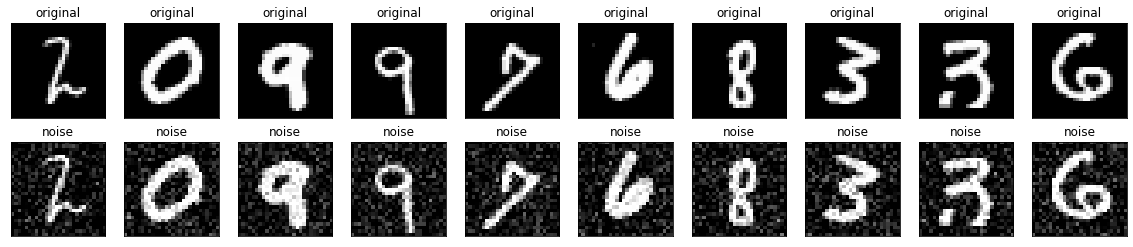

In [9]:
plt.figure(figsize=(20, 4))

i = 0
for img, targ in train_ds:
  if i < 10:
    # display original
    ax = plt.subplot(2, 10, i+1)
    plt.title("original")
    plt.imshow(tf.squeeze(targ[31]).numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, 10, i + 10 + 1 )
    plt.title("noise")
    plt.imshow(tf.squeeze(img[31]).numpy())
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
  i = i+1
plt.show()

# Training

In [10]:
### Hyperparameters
num_epochs = 10
learning_rate = 0.001
    
# Initialize the optimizers: Adam
optimizer = tf.keras.optimizers.Adam(learning_rate)

tf.keras.backend.clear_session()

# Initialize the model.
model = ConvAutoencoder()
# Initialize the loss
loss = tf.keras.losses.MeanSquaredError()


# Initialize lists for later visualization.
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []


Original and denoised image : 


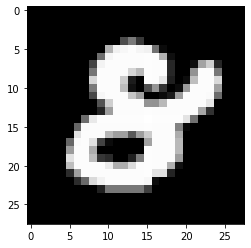

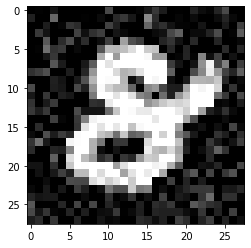

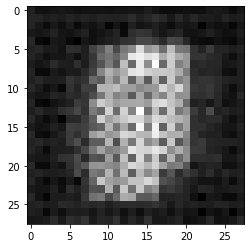

Original and denoised image : 


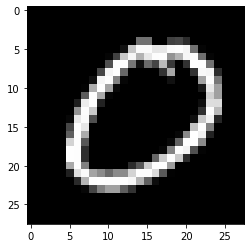

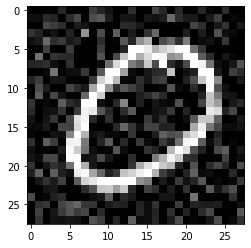

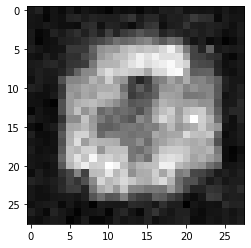

Original and denoised image : 


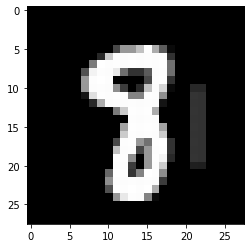

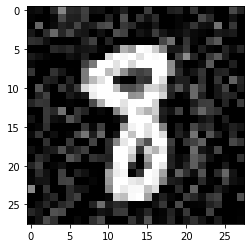

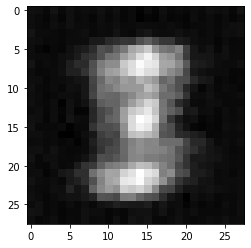

Original and denoised image : 


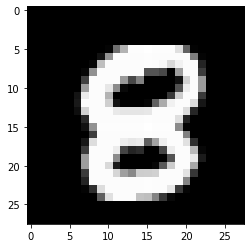

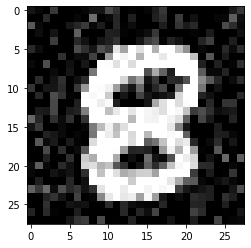

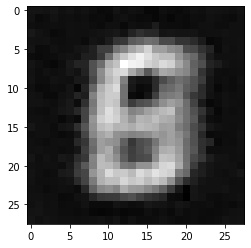

Original and denoised image : 


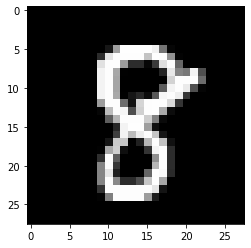

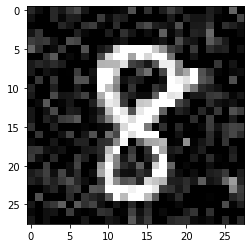

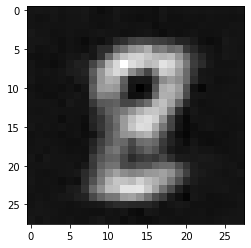

Original and denoised image : 


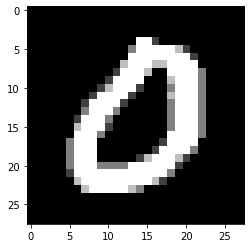

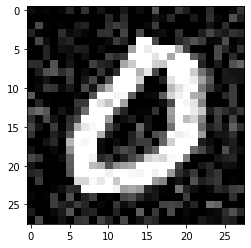

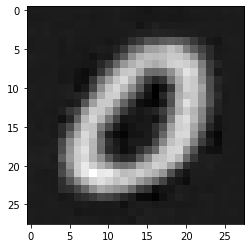

Original and denoised image : 


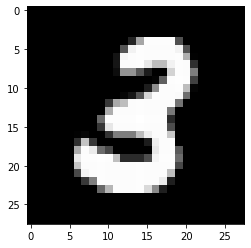

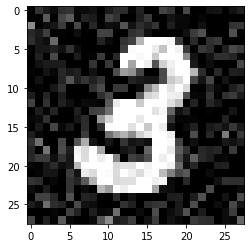

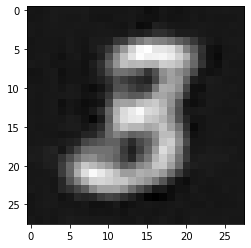

Original and denoised image : 


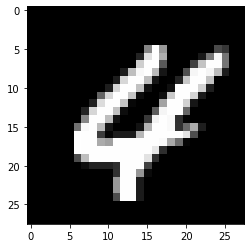

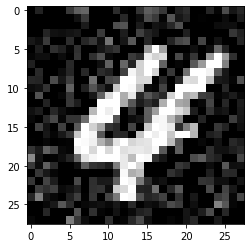

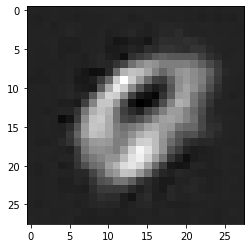

Original and denoised image : 


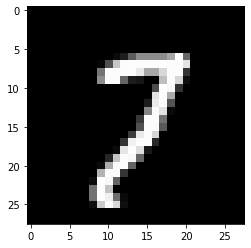

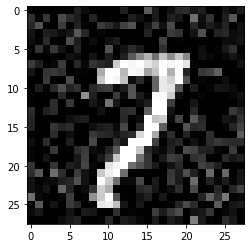

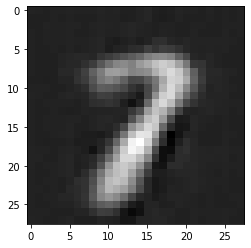

Original and denoised image : 


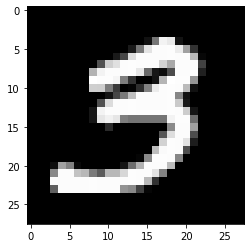

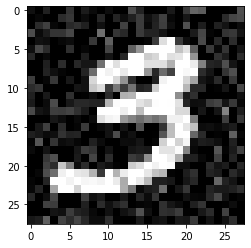

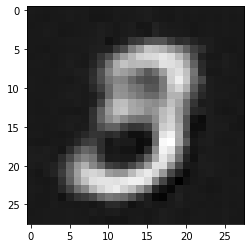

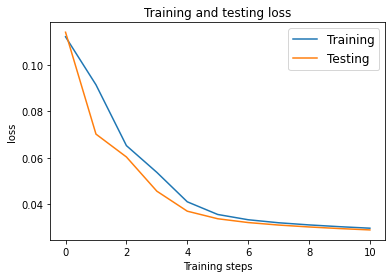

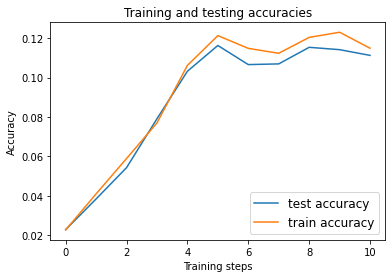

In [11]:
#testing once before we begin
test_loss, test_accuracy, _ = test(model, test_ds, loss, visualize = False)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy, _ = test(model, train_ds, loss, visualize = False)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)


# We train for num_epochs epochs
for epoch in range(num_epochs):

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input,target in train_ds:
        train_loss, train_accuracy = train_step(model, input, target, loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    # tracking train accuracy
    train_accuracies.append(tf.reduce_mean(train_accuracy))
    
    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy, _ = test(model, test_ds, loss, visualize = True)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    
    #print(f' test_losses: {test_losses[-1]} , test_accuracies: {test_accuracies[-1]}')
visualization(train_losses, test_losses, train_accuracies, test_accuracies)

# Analysis TSNE

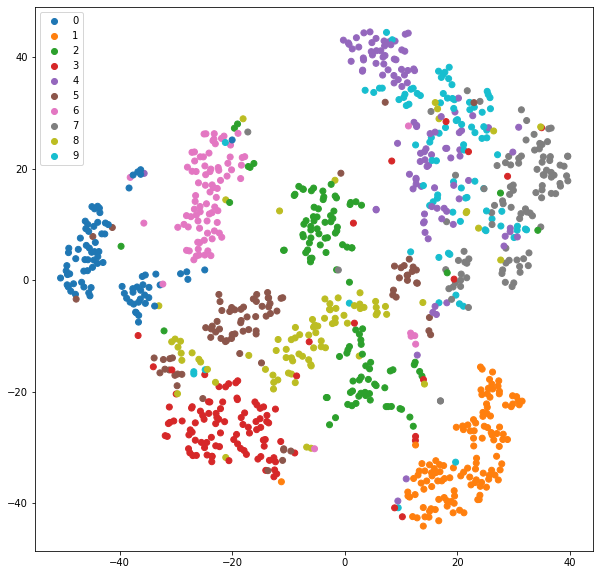

In [15]:
x = test_d[:1000]
x_labels = test_labels[:1000]
x = tf.expand_dims(tf.cast(x, tf.float32)/255., -1)
encoded = model.encoder(x)
encoded = np.reshape(encoded, (encoded.shape[0], -1))

embedded = TSNE(n_components=2, learning_rate='auto', perplexity=20, init = 'random').fit_transform(encoded)
label_names=[str(l) for l in np.arange(10)]
fig = plt.figure(figsize=(10, 10))
scatter = plt.scatter(embedded[:,0], embedded[:,1], c=x_labels, cmap='tab10')
plt.legend(handles=scatter.legend_elements()[0], labels=label_names)